In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
#pd.options.display.max_columns = 9000
dataframe = pd.read_csv('C:/Users/Chidinma Anunike/Desktop/Machine Learning datasets/More ML/Sunflower challenge 2021/Clean/dataset1_train_Stripped.txt', sep = '\t')
dataframe.columns = dataframe.columns.map(lambda x : x.replace("-", "_").replace(" ", "_"))
dataframe.head()

,Cultivar,location_name,year,experiment_no,Yield
0,1309,61,2020,5,23.2468
1,1133,16,2019,31,34.3250
2,2600,36,2019,137,31.3832
3,4698,41,2019,123,11.4865
4,581,72,2020,28,32.0508


In [13]:
X = dataframe.iloc[:, 0: 4]
y = dataframe.iloc[:, -1]
print(X.shape)
print(y.shape)

(40675, 4)
(40675,)


In [14]:
X.isnull().sum()

Cultivar         0
location_name    0
year             0
experiment_no    0
dtype: int64

In [15]:
y.isnull().sum()

740

In [17]:
y.fillna(dataframe['Yield'].mean(), inplace = True)
y.isnull().sum()

0

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 7)
print( X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(27252, 4)
(13423, 4)
(27252,)
(13423,)


In [35]:
### Deal with Outliers
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)
#Select rows that are nor outliers
mask = yhat != -1

In [36]:
#wrap train set with lof model
X_train, y_train = X_train[mask], y_train[mask]
print(X_train.shape, y_train.shape)

(26150, 4) (26150,)


### RandomForest Model

In [41]:
## Model Development
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
model = RandomForestRegressor()
model.fit(X_train, y_train)


RandomForestRegressor()

In [43]:
pred_test = model.predict(X_test)
pred_test

array([41.02625   , 39.514903  , 10.541755  , ..., 33.317635  ,
       22.87788   , 21.56771738])

In [46]:
result = model.score(X_test, y_test)
print('Accuracy: %.3f%% ' % (result * 100))
print('MSE: ', mean_squared_error(y_test, pred_test))
print('MAE : ', mean_absolute_error(y_test, pred_test))
print('RMSE :', np.sqrt(np.mean(np.square(pred_test - y_test))))

Accuracy: 84.923% 
MSE:  14.279029661823246
MAE :  2.7783507697229908
RMSE : 3.778760334001511


In [47]:
import xgboost as xgb

In [50]:
#convert dataset into an optimised data structure Dmatrix
xdata_dmatrix = xgb.DMatrix(data = X, label = y)

In [51]:
#Tuning the hyperparameters

In [133]:
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror',
                         colsample_bytree = 1, learning_rate = 0.1,
                         max_depth = 20, alpha = 10, n_estimators = 100 )
xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)

In [134]:
result = xg_reg.score(X_test, y_test)
print('Accuracy: %.3f%% ' % (result * 100))
rmse = np.sqrt(mean_squared_error(y_test, preds))
print('RMSE : %f' %(rmse))

Accuracy: 87.120% 
RMSE : 3.492502


### XGBoost with CV

In [136]:
xdata_dmatrix = xgb.DMatrix(data = X, label = y)

In [195]:
params = {"objective": "reg:squarederror", "colsample_bytree": 0.9,
          "learning_rate": 0.1, "max_depth": 20, "alpha": 10}
results = xgb.cv(dtrain = xdata_dmatrix, params = params, nfold = 50,
                num_boost_round = 120, early_stopping_rounds = 20, metrics = 'rmse',
                 as_pandas = True, seed = 1)

In [196]:
results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,26.528862,0.006388,26.528870,0.342811
1,24.013086,0.101578,24.015031,0.338484
2,21.784409,0.147517,21.786487,0.296258
3,19.751648,0.176997,19.754978,0.287346
4,17.935508,0.175220,17.940308,0.277636


In [197]:
#Print final booting round metric
print((results['test-rmse-mean']).tail(1))

119    3.312622
Name: test-rmse-mean, dtype: float64


In [198]:
import matplotlib.pyplot as plt
import seaborn as sns

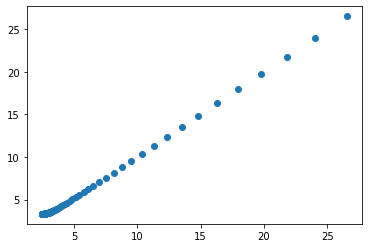

In [199]:
plt.scatter(results['train-rmse-mean'], results['test-rmse-mean']);

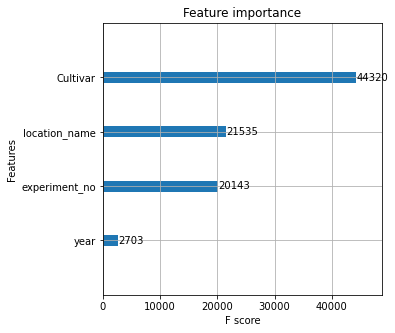

In [208]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 15]
plt.show()